In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# this could possibly also be read from metadata (comment in the first lines of the csv)
# sampling rate in milliseconds
sampling_rate = 100

dance = pd.read_csv("../data/HIMU-2020-05-19_08-06-24.csv", skiprows=3)
dance.describe()

,accelerometer_lsm6ds3_c.x,accelerometer_lsm6ds3_c.y,accelerometer_lsm6ds3_c.z,linear_Acceleration.x,linear_Acceleration.y,linear_Acceleration.z,rotation_Vector.x,rotation_Vector.y,rotation_Vector.z
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,-0.673344,-6.592160,0.854155,-0.066730,-0.016694,-0.127715,-0.392739,0.424518,-0.117859
std,3.012476,5.364940,4.755133,1.828694,2.342598,1.488143,0.271276,0.205043,0.550302
min,-7.365723,-17.384605,-10.219688,-5.751900,-8.183900,-4.310300,-0.686178,-0.252990,-0.759597
25%,-1.704932,-10.113333,-2.067123,-0.737425,-0.905650,-0.978325,-0.560507,0.295660,-0.445490
50%,-0.969891,-8.286547,-0.646420,0.040600,0.125500,-0.089900,-0.498702,0.501018,-0.376055
75%,-0.157998,-3.668295,1.018388,0.631925,1.434500,0.782675,-0.410995,0.571240,-0.230960
max,19.723875,4.636582,12.516015,9.362699,7.379300,5.812400,0.632153,0.667891,0.989761


Depending on what comments are in the csv-file (=lines starting with `@`) You might need to change the skipRows
parameter above.

Once we have imported a csv HyperIMU series, we want to start cleaning it.

But first, let's look at some parts of our dataFrame: the linear_acceleration and rotation_vector data

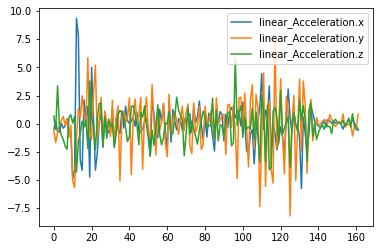

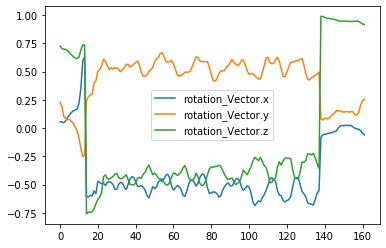

In [24]:
dance[['linear_Acceleration.x', 'linear_Acceleration.y', 'linear_Acceleration.z']].plot()
dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()

From the rotation vector data, we can easily see that in this example the phone was probably moved to the pocket somewhere
around point 0-25 and out of the pocked around points 135 - 160.

Therefore we can just cut the dataset and use only the rows 25 to 135.

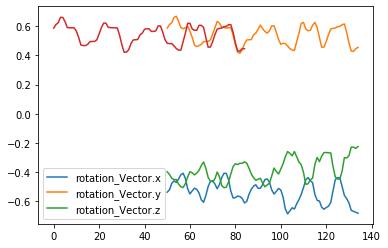

In [26]:
# the start and end variables can later be algorithmically approximated.
# For now, estimating them as constants based on the graph above works just fine.
# TODO: maybe this can also be approximated using the Ambient light sensor in the smartphone?
start=25
end=135
dance = dance.iloc[start:end]
dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()


# plt.plot(signal.medfilt(dance['rotation_Vector.y']))

# Finding the peaks
For finding the peaks, we need to find out what the bpm and beats per measure of our current song is:

Luckily, we can use the [get-audio-features spotify-API call](https://developer.spotify.com/console/get-audio-features-track/) for that.

If we call that API with the song ID of Ed Sheeran's Shape of You (```7qiZfU4dY1lWllzX7mPBI3```) we get the following response:


In [30]:
spotify_response = {
  "danceability": 0.825,
  "energy": 0.652,
  "key": 1,
  "loudness": -3.183,
  "mode": 0,
  "speechiness": 0.0802,
  "acousticness": 0.581,
  "instrumentalness": 0,
  "liveness": 0.0931,
  "valence": 0.931,
  "tempo": 95.977,
  "type": "audio_features",
  "id": "7qiZfU4dY1lWllzX7mPBI3",
  "uri": "spotify:track:7qiZfU4dY1lWllzX7mPBI3",
  "track_href": "https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3",
  "duration_ms": 233713,
  "time_signature": 4
}
time_signature = spotify_response['time_signature']
bpm = spotify_response['tempo']
duration = spotify_response['duration_ms'] / 1000

time_between_beats = 60 / bpm * 2